# Moving-average smoothing and seasonal decomposition

We will illustrate a common approach to decomposing data into trend and seasonal components, using moving-average smoothing to calculate the trend.

This is a fairly simple analysis that will also introduce us to some basic statistics tools in Python.

First we will import the necessary packages.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import fredapi

from statsmodels.tsa.seasonal import seasonal_decompose

Next we import our API key for the FRED system. <b>You will need to change this line of code in order to run this notebook on your own computer.</b> Either import a text file with your own API key, or just type the key directly into the code after the equals sign.

In [2]:
Fred_API_key_string = open('/home/william/Fred_API_key.txt').read().rstrip()

The dataset we will use is aggregate nonfarm payrolls (PAYNSA), published by the Bureau of Labor Statistics ([link](https://fred.stlouisfed.org/series/PAYNSA)).

PAYNSA is released monthly, and exhibits clear seasonality. Part of our goal in this analysis is to separate the trend and seasonality components in this data. We will compare our results with a seasonally-adjusted version of the payrolls data (PAYEMS), which is also published by BLS and follows a more complex methodology than what we will pursue here ([link](https://fred.stlouisfed.org/series/PAYEMS)).

For this course, you do not need to study the details of code blocks that download data into our notebooks 
(although you might find this useful for your own learning).
Our focus is on the analysis, so I will always give you the code you need for the data import step.

In [3]:
PAYNSA  = fredapi.Fred(api_key=Fred_API_key_string).get_series('PAYNSA', 
        observation_start = '2000-01-01', observation_end = '2023-12-31', 
        frequency='m', aggregation_method='eop')
PAYNSA = PAYNSA / 1000
PAYEMS  = fredapi.Fred(api_key=Fred_API_key_string).get_series('PAYEMS', 
        observation_start = '2000-01-01', observation_end = '2023-12-31', 
        frequency='m', aggregation_method='eop')
PAYEMS = PAYEMS / 1000

Plot the raw data: Notice the effect of seasonal adjustment.

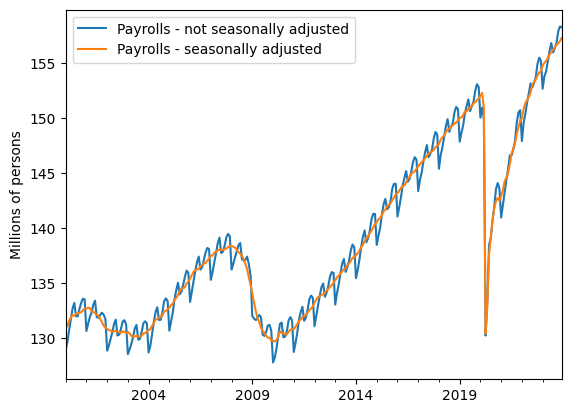

In [4]:
PAYNSA.plot(legend=True,label="Payrolls - not seasonally adjusted",ylabel="Millions of persons");

PAYEMS.plot(legend=True,label="Payrolls - seasonally adjusted");

Use the statsmodels function "seasonal_decompose" to visualize the trend and seasonal components of the raw data. It plots the raw data first, then the "trend," "seasonal," and "residual" components. We will reproduce these figures by hand to understand how they were built.

It's important to point out that this is not the only possible approach to extracting trend and cycle components from a data series. And, just because we can draw figures like this, does not necessarily mean that they are revealing anything deep about the data. For now, just think of them as tools for visualization. 

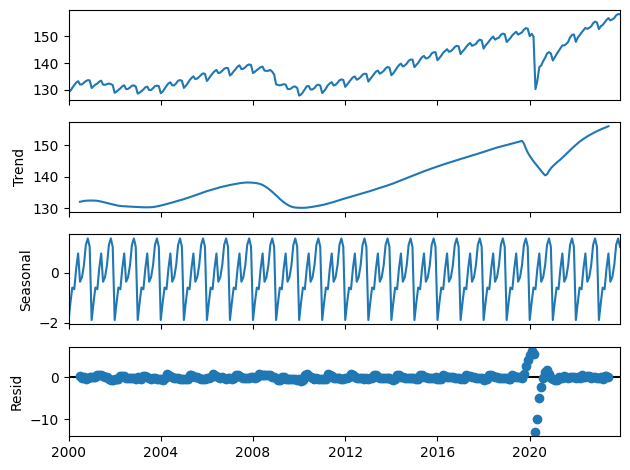

In [5]:
seasonal_decompose(PAYNSA,period=12).plot();

Match the output of this function by hand:

First plot just the "trend" figure that was produced by the function:

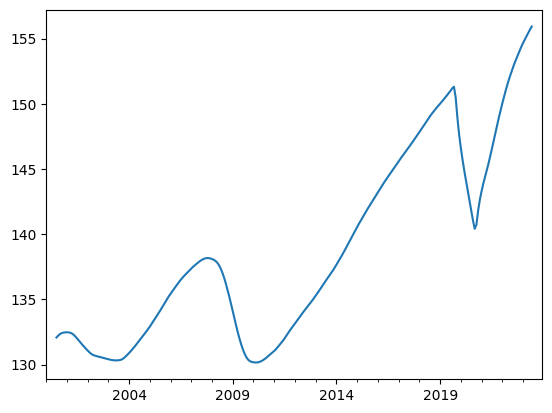

In [6]:
seasonal_decompose(PAYNSA,period=12).trend.plot();

The figure above is just plotting a <b>centered moving average</b> of order $m=12$.
As described in the slides, the formula for this is
$$
CMA_t = \frac{1}{12}\left( \frac{1}{2} y_{t-6} \, + \, y_{t-5} \, + \, ... \, + \, y_{t+5} \, + \, \frac{1}{2} y_{t+6} \right)
$$
Why does the formula look this way? What we want to do is to take an average over 12 months, centered at month $t$. But these two requirements contradict each other because 12 is an even number. So the convention is to average over one extra month (so 13 months total), with only 1/2 weight on the first and last month, so that the total weights still add up to 12.

Based on this formula, we can reproduce the figure above with the following code. In the code, we use the Pandas "shift" function, which returns a modified series that is shifted backwards in time by the specified number. We can use this to capture the terms in the formula above: $y_{t-6}$ corresponds with PAYNSA.shift(6), etc. To shift forward in time you use negative numbers. (Notice that a slash \ tells Python to continue the same command on the next line.)

The commented line of code (starting with #) shows a shorter way of writing the same thing. For those who want to build up Python expertise, this might be useful to study. 
The code uses the function sum(), which adds up a list of numbers. 
Inside the sum function, the list of numbers is created by the bracketed expression, which is an example of a **list comprehension.** This is a condensed way of writing a loop, unique to Python. 
The example here creates a list [PAYNSA.shift(5), PAYNSA.shift(4), ...] and then the sum() adds them all up. (Notice that PAYNSA.shift(0) just returns PAYNSA with no changes.)
The range() function is the standard way to create a list of numbers in Python:

- range(x,y) will return the numbers from x *increasing* up to y, but *not including* y. For example, range(1,5) will return 1,2,3,4. If y is less than or equal to x, then range(x,y) will not include anything at all. 
- range(x,y,z) will return the numbers starting at x, ending at y (without including it), and stepping by the amount z at each step. So for example range(0,10,2) will return 0,2,4,6,8. 
- We can use z=-1 to make the function count downward. So in the case at hand, range(5,-6,-1) returns 5,4,3,2,1,0,-1,-2,-3,-4,-5.

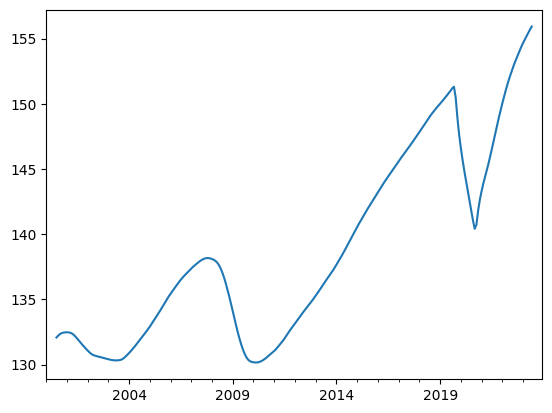

In [7]:
PAYNSA_CMA = (1/12)*( 0.5*PAYNSA.shift(6) + PAYNSA.shift(5) + PAYNSA.shift(4) + PAYNSA.shift(3) \
                    + PAYNSA.shift(2) + PAYNSA.shift(1) + PAYNSA + PAYNSA.shift(-1) + PAYNSA.shift(-2) \
                    + PAYNSA.shift(-3) + PAYNSA.shift(-4) + PAYNSA.shift(-5) + 0.5*PAYNSA.shift(-6) )

PAYNSA_CMA = (1/12)*( 0.5*PAYNSA.shift(6) + sum([PAYNSA.shift(i) for i in range(5,-6,-1)]) + 0.5*PAYNSA.shift(-6) )

PAYNSA_CMA.plot();

This figure exactly matches the earlier output from the seasonal_decompose() function. We can also compare it with the BLS seasonally-adjusted series PAYEMS (see figure below). The basic pattern is the same, but you can see some clear differences as well. Again, there are many different potential approaches to smoothing and seasonal adjustments.

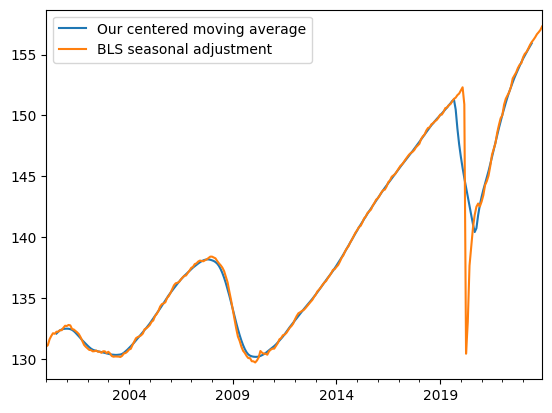

In [8]:
PAYNSA_CMA.plot(legend=True,label="Our centered moving average")
PAYEMS.plot(legend=True,label="BLS seasonal adjustment");

Now plot the "seasonal" figure that was produced by the function. 

That figure repeats itself for every year, so I will pick a specific year at random (2000) to plot.

The clear pattern we see is that payrolls spike just before the start of the summer, then drop off during the summer, and then rise to their highest levels at the end of the year.

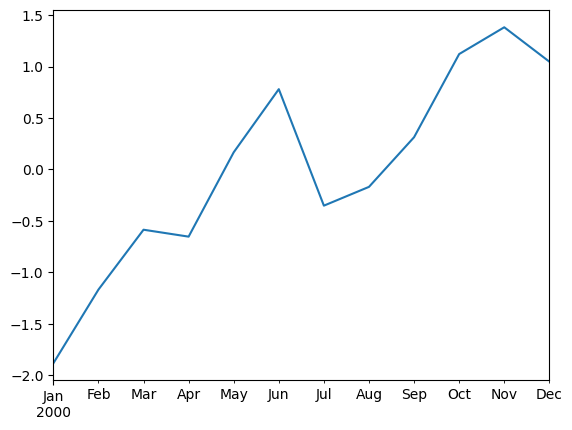

In [9]:
seasonal_decompose(PAYNSA,period=12).seasonal['2000'].plot();

We can reproduce this figure by the following process:
1. Calculate a "detrended" version of the payrolls data, as the raw data minus the CMA that we calculated above.
2. Calculate the mean of this detrended data separately for each month in the year.
3. Recenter these averages by subtracting out *their* average across all 12 months.

The loop in the code below features another example of the range() function in Python. Again notice that the second input to this function should be one *more* than the last value we want to loop over.

The commented line shows how to replace the loop with a list comprehension.

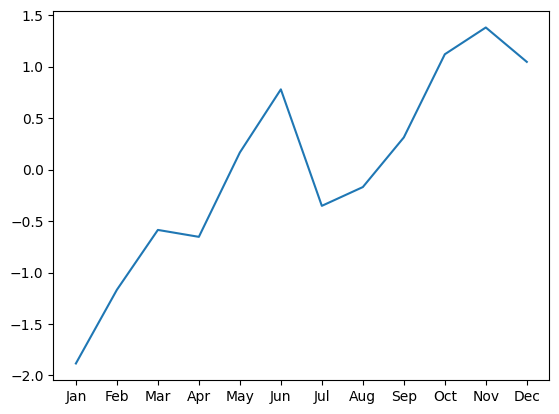

In [10]:
PAYNSA_detrend = PAYNSA - PAYNSA_CMA

PAYNSA_seas = np.array(np.zeros(12))
for i in range(1,13):
    monthly_values = PAYNSA_detrend[PAYNSA_detrend.index.month == i]
    PAYNSA_seas[i-1] = monthly_values.mean()

# PAYNSA_seas = np.array( [ PAYNSA_detrend[PAYNSA_detrend.index.month == i].mean() for i in range(1,13) ] )

PAYNSA_seas = PAYNSA_seas - PAYNSA_seas.mean()

plt.plot(PAYNSA_seas);
plt.xticks(ticks=[i for i in range(0,12)],labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']);

Finally, the "residual" figure from seasonal_decompose is just the part of the series that was not trend or seasonal. For completeness we can reproduce this figure as well.

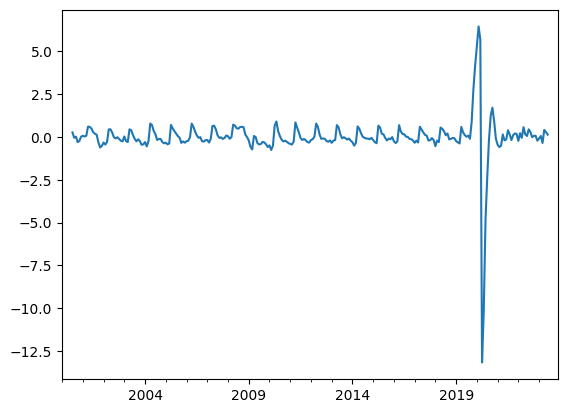

In [11]:
seasonal_decompose(PAYNSA).resid.plot();

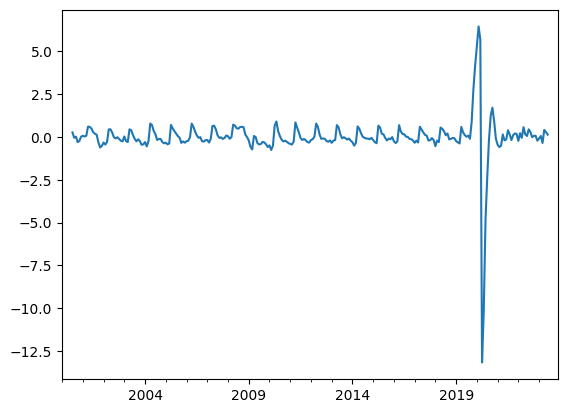

In [12]:
PAYNSA_resid = PAYNSA - PAYNSA_CMA - PAYNSA_seas[PAYNSA.index.month.values - 1]

PAYNSA_resid.plot();